In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the CIFAR10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Use a subset if necessary
# Subset dataset to first 10000 samples if memory issues occur
# train_dataset = torch.utils.data.Subset(train_dataset, range(10000))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# Function to display images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize if necessary
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)  # Change dataiter.next() to next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:4]))

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder Layers
        self.enc_conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)   # Output: 32x16x16
        self.enc_conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  # Output: 64x8x8
        self.enc_conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1) # Output: 128x4x4

        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)

        # Decoder Layers
        self.dec_fc = nn.Linear(latent_dim, 128 * 4 * 4)
        self.dec_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)   # Output: 64x8x8
        self.dec_conv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)    # Output: 32x16x16
        self.dec_conv3 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)     # Output: 3x32x32

    def encode(self, x):
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = F.relu(self.enc_conv3(x))
        x = x.view(-1, 128 * 4 * 4)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.dec_fc(z)
        x = x.view(-1, 128, 4, 4)
        x = F.relu(self.dec_conv1(x))
        x = F.relu(self.dec_conv2(x))
        x = torch.sigmoid(self.dec_conv3(x))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

Epoch 1, Average Loss: 102.8912
Original Images


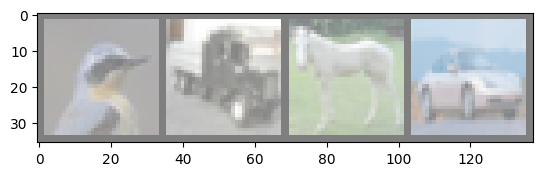

Reconstructed Images


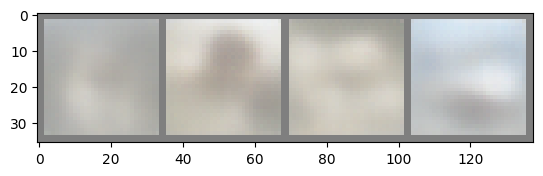

Epoch 2, Average Loss: 80.7768
Original Images


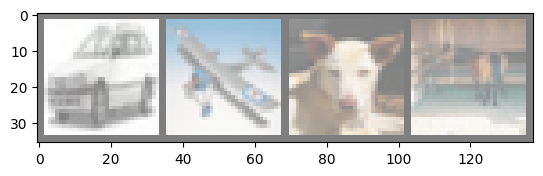

Reconstructed Images


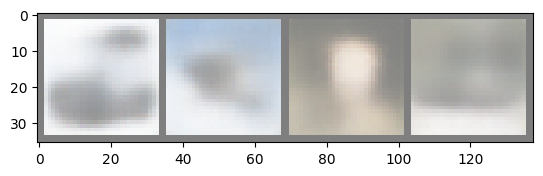

Epoch 3, Average Loss: 78.5435
Original Images


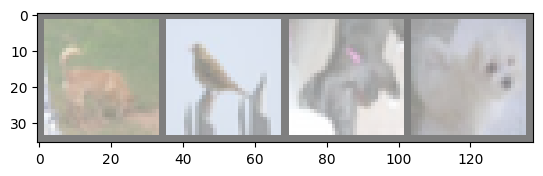

Reconstructed Images


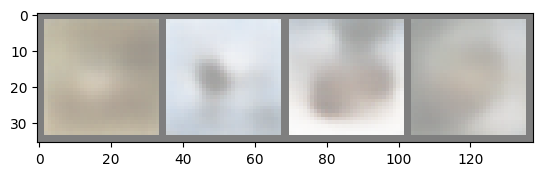

Epoch 4, Average Loss: 77.6276
Original Images


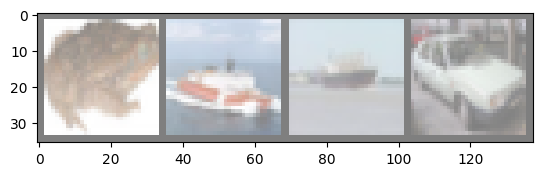

Reconstructed Images


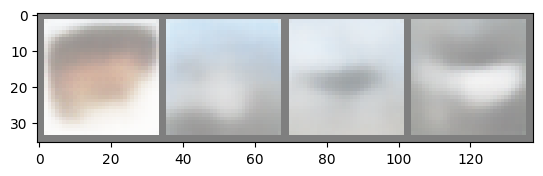

Epoch 5, Average Loss: 76.9893
Original Images


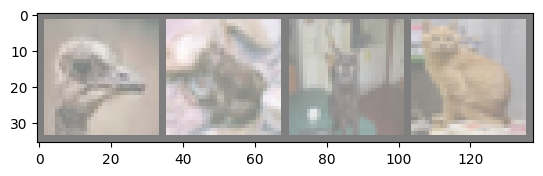

Reconstructed Images


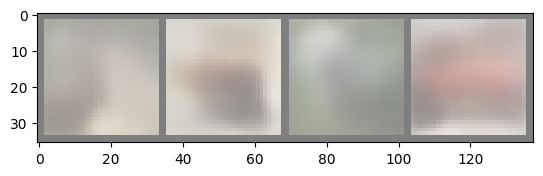

In [ ]:
import torch.optim as optim

# Initialize the model, optimizer, and loss function
latent_dim = 128
model = VAE(latent_dim=latent_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 5

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)

        # Compute Reconstruction Loss
        recon_loss = F.mse_loss(recon_batch, data, reduction='sum')

        # Compute KL Divergence
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        # Total Loss
        loss = recon_loss + kl_loss
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    average_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch {epoch + 1}, Average Loss: {average_loss:.4f}')

    # Compare input and reconstructed images
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(train_loader))
        recon_batch, _, _ = model(data)

        # Display original images
        print("Original Images")
        imshow(torchvision.utils.make_grid(data[:4]))

        # Display reconstructed images
        print("Reconstructed Images")
        imshow(torchvision.utils.make_grid(recon_batch[:4]))

Encoder Architecture: Three convolutional layers with increasing depth (32, 64, 128 filters) to extract hierarchical features from the images.
- **Latent Dimension (128)**: A latent space of 128 dimensions balances compression and the ability to capture meaningful representations without excessive loss of information.
- **Decoder Architecture**: Three transposed convolutional layers mirroring the encoder to reconstruct images from the latent representations.
- **Activation Functions**: ReLU activations are used in the hidden layers for non-linearity, and a sigmoid activation in the output layer to normalize pixel values between 0 and 1.
- **Loss Function**: Combines Mean Squared Error (MSE) for reconstruction loss and Kullback-Leibler Divergence (KL divergence) for the latent space regularization.

The loss function combines two components to train the Variational Autoencoder:

1. *Reconstruction Loss*:
   - *Purpose*: Measures how well the reconstructed images match the original images.
   - *Implementation*: Uses Mean Squared Error (MSE) between the input images data and the reconstructed images recon_batch.
   - *Code*:
     python
     recon_loss = F.mse_loss(recon_batch, data, reduction='sum')
     

2. *Kullback-Leibler (KL) Divergence*:
   - *Purpose*: Regularizes the latent space to follow a standard normal distribution, encouraging the model to learn meaningful latent representations.
   - *Implementation*: Calculates the divergence between the learned latent distribution (defined by mu and logvar) and a standard normal distribution.
   - *Code*:
     python
     kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
     

*Total Loss*: The sum of the reconstruction loss and the KL divergence guides the model to produce accurate reconstructions while maintaining a smooth latent space.
python
loss = recon_loss + kl_loss